# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Regression" data-toc-modified-id="Regression-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Regression</a></div><div class="lev2 toc-item"><a href="#Divine-Comedy" data-toc-modified-id="Divine-Comedy-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Divine Comedy</a></div><div class="lev4 toc-item"><a href="#Generate" data-toc-modified-id="Generate-0201"><span class="toc-item-num">0.2.0.1&nbsp;&nbsp;</span>Generate</a></div><div class="lev2 toc-item"><a href="#Very-short-text" data-toc-modified-id="Very-short-text-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Very short text</a></div><div class="lev4 toc-item"><a href="#Generate-dataset-for-seq2seq-RNN" data-toc-modified-id="Generate-dataset-for-seq2seq-RNN-0301"><span class="toc-item-num">0.3.0.1&nbsp;&nbsp;</span>Generate dataset for seq2seq RNN</a></div><div class="lev4 toc-item"><a href="#Robbie-Williams-Dataset" data-toc-modified-id="Robbie-Williams-Dataset-0302"><span class="toc-item-num">0.3.0.2&nbsp;&nbsp;</span>Robbie Williams Dataset</a></div>

In [1]:
import dlutils
% matplotlib inline

def to_str(data, translator):
    return ''.join(translator.to_symbol(data))

## Regression

In [2]:
N = 101
data = np.sin(2 * np.pi * np.arange(N) / 20)

# filtered noise
data = np.random.randn(N)
#h = sp.signal.firwin(1, .1)
#data = sp.signal.lfilter(h, 1, data)

In [3]:
data = np.expand_dims(data, -1)
N_split = 1
slen = data.shape[0] // N_split
data = [data[i*slen:(i+1)*slen, :] for i in range(N_split)]

In [4]:
batch_size = 1
rnn_layers = [{'num_units': 32}, {'num_units': 32}]
dense_layers = [{'num_units': 1, "activation": "tanh"}]
nfolds = 1
max_epochs = 128
keep_prob = 1.0
learning_rate = 0.1
optimizer = "Adam"

In [5]:
data_inputs, data_targets = dlutils.dataset.LM_input_and_targets_from_inputs(data)
dataset = dlutils.dataset.Dataset_seq2seq(data_inputs, data_targets)

In [6]:
input_stage = dlutils.models.RNNLM_TF_InputStage_Regression(1)
output_stage = dlutils.models.RNNLM_TF_OutputStage_Regression(1)
feedback_stage = dlutils.models.RNNLM_TF_FeedbackStage_Noop()
model = dlutils.models.RNNLM_TF(input_stage, output_stage, feedback_stage, rnn_layers, dense_layers, 
                         init_scale=0.1, optimizer=optimizer, learning_rate=learning_rate, 
                         keep_prob=keep_prob)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [83]:
logger = dlutils.train.HtmlLogger("./log_dir", "loss", log_every_step=10)
trainer = dlutils.train.rnn.Trainer(dataset, model, batch_size=batch_size, logger=logger, nfolds=nfolds, max_fold=1, max_epochs=max_epochs, save_every=10)

In [85]:
model.set_learning_rate(0.01)

In [86]:
trainer.train(contd=False)

new model:  ./log_dir/20170210093039.json ./log_dir/20170210093039.html


In [13]:
data = np.sin(2 * np.pi * np.arange(100000) / 20)
data = np.expand_dims(data, -1)

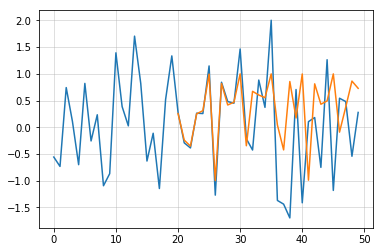

In [87]:
ofs = 40
priming_len = 20
priming_seq = data[0][ofs:ofs+priming_len, :]
length = 30
outputs = model.generate(priming_seq, length)
outputs = np.array(outputs)
plt.plot(np.arange(priming_len+length), data[0][ofs:ofs+priming_len+length, :])
plt.plot(priming_len + np.arange(length), outputs[:, 0])
plt.grid(alpha=.5)

## Divine Comedy

In [9]:
with open('data/ladivinacommedia.txt', 'r') as f:
    data = f.read()
data = data.lower().split(sep='\n\n')
data = [list(d) for d in data]

In [10]:
batch_size = 16
vocabulary_size = 40
rnn_layers = [{'num_units': 32}, {'num_units': 32}]
dense_layers = [{'num_units': vocabulary_size}]
nfolds = 1
max_epochs = 1024
keep_prob = 1.0
learning_rate = 0.1
optimizer = "Adam"

In [11]:
translator = dlutils.dataset.DatasetTranslator(data, vocabulary_size=vocabulary_size)
data_int = translator.to_int(data)
data_int = [np.expand_dims(d, -1) for d in data_int]
data_int = data_int[0:2]
nsymbols = len(translator.alphabet)

In [12]:
data_inputs, data_targets = dlutils.dataset.LM_input_and_targets_from_inputs(data_int)
dataset = dlutils.dataset.Dataset_seq2seq(data_inputs, data_targets)

In [18]:
input_stage = dlutils.models.RNNLM_TF_InputStage_OneHot(vocabulary_size)
output_stage = dlutils.models.RNNLM_TF_OutputStage_Classification(vocabulary_size)
feedback_stage = dlutils.models.RNNLM_TF_FeedbackStage_Sampler(temperature=.7, avoid=[translator.unknown_int])
model = dlutils.models.RNNLM_TF(input_stage, output_stage, feedback_stage, rnn_layers, dense_layers, 
                         init_scale=0.1, optimizer=optimizer, learning_rate=learning_rate, 
                         keep_prob=keep_prob)

In [15]:
logger = dlutils.train.HtmlLogger("./log_dir", "loss")
trainer = dlutils.train.rnn.Trainer(dataset, model, batch_size=batch_size, logger=logger, nfolds=nfolds, max_epochs=max_epochs, save_every=10)

In [ ]:
trainer.train()

#### Generate

In [16]:
rnn_layers = [{'num_units': 512}, {'num_units': 512}]
dense_layers = [{'num_units': vocabulary_size}]

In [19]:
model.load('models/20170102093806_0_100.ckpt')

In [21]:
priming_seq_len = 64
iseq = 0
ofs = 0
priming_seq = data_int[iseq][ofs:priming_seq_len+ofs, :]
priming_seq = priming_seq[:, 0]
priming_str = to_str(priming_seq, translator)
print(priming_str)

nel mezzo del cammin di nostra vita
mi ritrovai per una selva os


In [ ]:
probs = model.predict(np.expand_dims(priming_seq, 0))
for i in np.argsort(probs[0]):
    print(translator.to_symbol(i), probs[0, i])

In [22]:
length = 1000
outputs = model.generate(priming_seq, length)
out_list = [o_[0] for o_ in outputs]
out_str = to_str(out_list, translator)
print(priming_str + out_str)

nel mezzo del cammin di nostra vita
mi ritrovai per una selva ospinta:
disse: «e qui s'attrasse il disio,
per lo sol circila ancor, fior nel foco,
ch'è donna ascaltar nel primo vento,
se si piovvò li occhi sommate d'almi,
quando veder dove soto mai ci darte,
e ver' lo terpo la mente trove,
sì che fu costui fin che mi fece affonno,
lo monte fermo ad ogne ver' lui,
per tra donna de la volla e l'intra traggole,
simile il duca mio, mo acqua non compo
a le sue parole per deperte immanni:
«se tu veder pur rive ne la forza,
sù ch'al perto che ne l'altre sermine
tarder mi porse a la feste in solo,
come fier men ciò che ne la costa,
d'i passi sotto per l'alta per te le melli,
come le denti a che sù lo strave
a me imperador che tu tempre celo,
e va 'l fosso stesso un pinto semisto
tenne creder, venimmo in cotal face!».
veggio; ma la parole non strette,
e quel con altro pensava con arti,
sì che, sovra sette oncrarmi al primo;
e dimmi, forse logdo e quel mente
a l'altro donno, e vuol che mi tacque

## Very short text

In [2]:
import dlutils

In [3]:
batch_size = 2
vocabulary_size = None
rnn_layers = [{'num_units': 32}]
keep_prob = 1
nfolds = 1
max_epochs = 64
learning_rate = 0.1
optimizer = "Adam"

In [4]:
data = ["Hello Bruno, how are you?", "Patrick Rothfuss le cronache dell'assassino del re"]
# data = ["Hello Bruno, how are you?"]
data = [list(d) for d in data]
translator = dlutils.dataset.DatasetTranslator(data, vocabulary_size=vocabulary_size)
data_int = translator.to_int(data)
data_int = [np.expand_dims(d, -1) for d in data_int]
nsymbols = len(translator.alphabet)
dense_layers = [{'num_units': nsymbols}]
print(translator.conf)

{'nsymbols': 25, 'alphabet': [' ', "'", ',', '?', 'B', 'H', 'P', 'R', 'a', 'c', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'n', 'o', 'r', 's', 't', 'u', 'w', 'y'], 'entropy': 2.9147375}


In [5]:
data_inputs, data_targets = dlutils.dataset.LM_input_and_targets_from_inputs(data_int)
dataset = dlutils.dataset.Dataset_seq2seq(data_inputs, data_targets)

In [6]:
input_stage = dlutils.models.RNNLM_TF_InputStage_OneHot(nsymbols)
output_stage = dlutils.models.RNNLM_TF_OutputStage_Classification(nsymbols)
feedback_stage = dlutils.models.RNNLM_TF_FeedbackStage_Sampler()
model = dlutils.models.RNNLM_TF(input_stage, output_stage, feedback_stage, rnn_layers, dense_layers,
                         optimizer=optimizer, learning_rate=learning_rate, 
                         keep_prob=keep_prob)

In [7]:
# logger = dlutils.HtmlLogger("./log_dir", "loss", log_delta_sec=20)
trainer = dlutils.train.rnn.Trainer(dataset, model, batch_size=batch_size, logger=None, nfolds=nfolds, max_epochs=max_epochs)

In [8]:
trainer.train()

*** new model ***
{'batch_size': 2,
'dataset': {'max_len': 49,
           'min_len': 24,
           'name': '',
           'nseq': 2,
           'slen': array([24, 49]),
           'tot_len': 73},
'max_epochs': 64,
'model': {'dense_layers': [{'num_units': 25}],
         'feedback_stage': {'avoid': [],
                           'name': 'RNNLM_TF_FeedbackNoop',
                           'temperature': 1.0},
         'grad_clip': 5.0,
         'init_scale': 0.1,
         'input_stage': {'input_size': 1,
                        'name': 'RNNLM_TF_InputStage_OneHot',
                        'output_size': 25},
         'keep_prob': 1,
         'learning_rate': 0.1,
         'optimizer': 'Adam',
         'output_stage': {'input_size': 25,
                         'name': 'RNNLM_TF_OutputStage_Classification',
                         'output_size': 25,
                         'target_size': 1},
         'rnn_layers': [{'num_units': 32}]},
'nfolds': 1,
'proportion': 1,
'save_every': 100}
**

In [ ]:
x = dataset.format(0)
for i, x_ in enumerate(x[0]):
    print(i)
    for x__, y__ in zip(x_[0], x_[1]):
        print(translator.to_symbol(x__), translator.to_symbol(y__))

In [14]:
ofs = 0
num_steps = 3
priming_seq = data_int[0][ofs:num_steps+ofs, :]
priming_str = to_str(priming_seq.flat, translator)
print(priming_str)

Hel


In [15]:
length = 80
outputs = model.generate(priming_seq, length)
out_str = to_str(np.array(outputs).flat, translator)
print(priming_str + out_str)

Hello Bruno, how are you?o, how are you?onBrwno, how are you?onache dell'assassino 


#### Generate dataset for seq2seq RNN

In [ ]:
size = 10000
in_size = 2
out_size = 2
deps_list = [
    {'delay': 3, 'in_symbol': 1, 'out_symbol': 1, 'add_prob': .5},
    {'delay': 8, 'in_symbol': 1, 'out_symbol': 1, 'add_prob': -.25},
]

In [ ]:
data = dlutils.gen_data_seq2seq(size, in_size, out_size, deps_list)

In [ ]:
dlutils.expected_cross_entropy(in_size, out_size, deps_list)

In [ ]:
batch_size = 256
rnn_layers = [{'num_units': 4, 'cell_type': 'Basic'}]
dense_layers = [{'num_units': out_size}]
keep_prob = 1
nfolds = 1
max_epochs = 10
learning_rate = 0.1
optimizer = "Adagrad"

In [ ]:
data_inputs, data_targets = dlutils.dataset.LM_input_and_targets_from_inputs([data[0]])
dataset = dlutils.dataset.Dataset_seq2seq(data_inputs, data_targets)

In [ ]:
input_stage = dlutils.models.RNNLM_TF_InputStage_OneHot(in_size)
output_stage = dlutils.models.RNNLM_TF_OutputStage_Classification(out_size)
feedback_stage = dlutils.models.RNNLM_TF_FeedbackStage_Noop()
model = dlutils.models.RNNLM_TF(input_stage, output_stage, rnn_layers, dense_layers,
                         optimizer=optimizer, learning_rate=learning_rate, 
                         keep_prob=keep_prob)

In [ ]:
logger = dlutils.HtmlLogger("./log_dir", "loss")
test = dlutils.RNNTest(dataset, model, batch_size=batch_size, logger=logger, nfolds=nfolds, max_epochs=max_epochs)

In [ ]:
test.test(False)

#### Robbie Williams Dataset

In [147]:
import re
import shutil

In [180]:
root = '/Users/brunodigiorgi/Downloads/RobbieWilliamsAnnotations/chords/'
for rootdir, dirnames, filenames in os.walk(root):
    for filename in filenames:
        if(filename in ['.DS_Store']):
            continue
        old_fn = os.path.join(rootdir, filename)
        year = re.search('chords/(\d\d\d\d)', fn).groups()[0]
        album = os.path.split(rootdir)[1].replace(' \'', '').replace('\'', '').replace(' ', '_')
        new_filename = 'robbie_williams_' + album + '_' + filename.replace(' \'', '').replace('\'', '').replace(' ', '_')
        new_filename = new_filename.replace('GTChords.txt', '.chords').replace('GTKeys.txt', '.keys')
        new_fn = os.path.join(root, new_filename)
        shutil.copy(old_fn, new_fn)

In [200]:
roots = [
    '/Users/brunodigiorgi/Downloads/RobbieWilliamsAnnotations/chords/',
    '/Users/brunodigiorgi/Downloads/RobbieWilliamsAnnotations/keys/',
    '/Users/brunodigiorgi/Downloads/RobbieWilliamsAnnotations/beats/'
]
    
fns = []
for i, root in enumerate(roots):
    fns.append([])
    for fn in os.listdir(root):
        if(os.path.isdir(os.path.join(root, fn))):
            continue
        if(fn == '.DS_Store'):
            continue
        fns[i].append(fn)
        # change mode to 0666
        os.chmod(os.path.join(root, fn), 0o666)

In [1]:
import dlutils

In [ ]:
dlutils.dataset.

In [99]:
N = 1000000
mean = 10
std = 20
x = std * np.random.randn(N) + mean

In [117]:
nsamples = 10000
N_sample = N // nsamples
x_samples = np.array([x[i*N_sample:(i+1)*N_sample] for i in range(nsamples)])
mean_samples = np.mean(x_samples, axis=-1)
std_samples = np.std(x_samples, axis=-1, ddof=0)

print('expected value of the mean:', np.mean(mean_samples))
print('std error of the mean:', np.std(mean_samples))
print('expected value of the std:', np.mean(std_samples))
print('std error of the std:', np.std(std_samples))

expected value of the mean: 10.0009292812
std error of the mean: 2.00312585157
expected value of the std: 19.8398298471
std error of the std: 1.39873333124


In [101]:
true_var = np.sum(np.square(x - np.mean(x))) / N
other_vars = [np.sum(np.square(x - (eps + np.mean(x)))) / N for eps in np.arange(-2, 2, .1)]

399.587816471


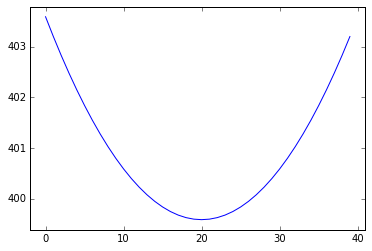

In [102]:
print(true_var)
plt.plot(other_vars)